In [1]:
%matplotlib inline
import pandas as pd
import datetime
# import pandas_datareader.data as web
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
print(torch.__version__)

1.0.1.post2


In [2]:
reqd_len = 150
channels = 3
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' : 
            self.df = pd.read_csv('../../data/train.csv', header = None)
        elif mode == 'test' : 
            self.df = pd.read_csv('../../data/test.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        assert(x.shape == (reqd_len, channels))
        return x
        
train_dataset = IMUDataset(mode = 'train')
test_dataset = IMUDataset(mode = 'test')

(128100, 8)
(16200, 8)


In [24]:
batch_size = 1
train_indices = [(i * reqd_len) for i in range(len(train_dataset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(test_dataset) // reqd_len)]

trainloader = DataLoader(train_dataset, batch_size = batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
trainloader2 = DataLoader(train_dataset, batch_size = 1, sampler = SubsetRandomSampler(train_indices), drop_last = True)
testloader2 = DataLoader(test_dataset, batch_size = 1, sampler = SubsetRandomSampler(test_indices), drop_last = True)

torch.Size([1, 150, 3])


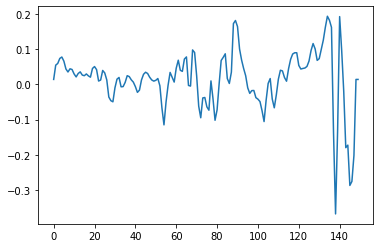

In [25]:
signal = next(iter(trainloader2))
print(signal.shape)
signal = signal.detach().numpy()
signal = np.transpose(signal).reshape(-1)
t = range(150)
plt.plot(t, signal[150 : 300])

In [26]:
# for xavier initialization of network
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class AutoEncoder(nn.Module) :
    def __init__(self) : 
        super(AutoEncoder, self).__init__()
        # defining layers
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels = 3, out_channels = 2, kernel_size = 5),
            nn.Tanh(),
            nn.Conv1d(in_channels = 2, out_channels = 1, kernel_size = 5),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels = 1, out_channels = 2, kernel_size = 5),
            nn.Tanh(),
            nn.ConvTranspose1d(in_channels = 2, out_channels = 3, kernel_size = 5)
        )
        self.classifier = nn.Sequential(
            nn.Linear(142, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5),
            nn.LogSoftmax(dim = 1)
        )
        
    def forward(self, x, encode = False, classify = False) :
        x = torch.transpose(x, 1, 2)
        features = self.encoder(x)
        
        if encode and not classify:
            return features
        elif not encode and classify :
            features = features.view(-1, 142)
            return self.classifier(features)
        else : 
            return self.decoder(features)

In [27]:
Net = AutoEncoder()
Net.apply(init_weights)
if torch.cuda.is_available() : 
    Net = Net.cuda()
    print('Model on GPU')

Model on GPU


In [28]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)

In [30]:
num_epochs = 100
total_step = len(train_dataset) // (batch_size * 150)
train_loss_list = list()
min_loss = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, signals in enumerate(trainloader) :
        if torch.cuda.is_available():
            signals = Variable(signals).cuda().float()
        else : 
            signals = Variable(signals).float()
        
        reconstr = Net.forward(signals)
        signal_ = torch.transpose(signals, 1, 2).float()
        loss = criterion(reconstr, signal_)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 200 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    if train_loss < min_loss : 
        min_loss = train_loss
        torch.save(Net.state_dict() , '../../saved_models/autoencoder7.pt')
        print('Saving model', min_loss)
    
    scheduler.step()

epoch =  0  step =  0  of total steps  854  loss =  0.00869990698993206
epoch =  0  step =  200  of total steps  854  loss =  0.032585516571998596
epoch =  0  step =  400  of total steps  854  loss =  0.023172056302428246
epoch =  0  step =  600  of total steps  854  loss =  0.0009092276450246572
epoch =  0  step =  800  of total steps  854  loss =  0.00606584781780839
Saving model 0.011337642566984153
epoch =  1  step =  0  of total steps  854  loss =  0.012556678615510464
epoch =  1  step =  200  of total steps  854  loss =  0.0006551140686497092
epoch =  1  step =  400  of total steps  854  loss =  0.010373554192483425
epoch =  1  step =  600  of total steps  854  loss =  0.03268825262784958
epoch =  1  step =  800  of total steps  854  loss =  0.008021609857678413
Saving model 0.011194883608038256
epoch =  2  step =  0  of total steps  854  loss =  0.00021926120098214597
epoch =  2  step =  200  of total steps  854  loss =  0.01704886183142662
epoch =  2  step =  400  of total step

epoch =  20  step =  400  of total steps  854  loss =  0.011495934799313545
epoch =  20  step =  600  of total steps  854  loss =  0.005814503878355026
epoch =  20  step =  800  of total steps  854  loss =  0.0005816861521452665
Saving model 0.010860136503287805
epoch =  21  step =  0  of total steps  854  loss =  0.0024538040161132812
epoch =  21  step =  200  of total steps  854  loss =  0.0018961777677759528
epoch =  21  step =  400  of total steps  854  loss =  0.011957035399973392
epoch =  21  step =  600  of total steps  854  loss =  0.009600561112165451
epoch =  21  step =  800  of total steps  854  loss =  0.01590006798505783
Saving model 0.010853099047985875
epoch =  22  step =  0  of total steps  854  loss =  0.017740653827786446
epoch =  22  step =  200  of total steps  854  loss =  0.0036586769856512547
epoch =  22  step =  400  of total steps  854  loss =  0.002737870905548334
epoch =  22  step =  600  of total steps  854  loss =  0.006172828376293182
epoch =  22  step =  

epoch =  40  step =  600  of total steps  854  loss =  0.0053263017907738686
epoch =  40  step =  800  of total steps  854  loss =  0.01631731167435646
Saving model 0.010815602462168842
epoch =  41  step =  0  of total steps  854  loss =  0.015258543193340302
epoch =  41  step =  200  of total steps  854  loss =  0.001534472918137908
epoch =  41  step =  400  of total steps  854  loss =  0.017812995240092278
epoch =  41  step =  600  of total steps  854  loss =  0.008257903158664703
epoch =  41  step =  800  of total steps  854  loss =  0.0005630623199976981
Saving model 0.010814858154913001
epoch =  42  step =  0  of total steps  854  loss =  0.017183417454361916
epoch =  42  step =  200  of total steps  854  loss =  0.002615454373881221
epoch =  42  step =  400  of total steps  854  loss =  0.004022224806249142
epoch =  42  step =  600  of total steps  854  loss =  0.00046372757060453296
epoch =  42  step =  800  of total steps  854  loss =  0.008314497768878937
epoch =  43  step =  

epoch =  60  step =  800  of total steps  854  loss =  0.0045051053166389465
Saving model 0.010811733891493619
epoch =  61  step =  0  of total steps  854  loss =  0.0011751942802220583
epoch =  61  step =  200  of total steps  854  loss =  0.021371990442276
epoch =  61  step =  400  of total steps  854  loss =  0.0052221729420125484
epoch =  61  step =  600  of total steps  854  loss =  0.024090101942420006
epoch =  61  step =  800  of total steps  854  loss =  0.011440963484346867
Saving model 0.010811721452916064
epoch =  62  step =  0  of total steps  854  loss =  0.008005518466234207
epoch =  62  step =  200  of total steps  854  loss =  0.012202654965221882
epoch =  62  step =  400  of total steps  854  loss =  0.016304858028888702
epoch =  62  step =  600  of total steps  854  loss =  0.0019805997144430876
epoch =  62  step =  800  of total steps  854  loss =  0.03426742926239967
Saving model 0.010811703102073415
epoch =  63  step =  0  of total steps  854  loss =  0.00887019652

epoch =  80  step =  800  of total steps  854  loss =  0.018831178545951843
Saving model 0.010811411879045574
epoch =  81  step =  0  of total steps  854  loss =  0.007631470914930105
epoch =  81  step =  200  of total steps  854  loss =  0.04591948911547661
epoch =  81  step =  400  of total steps  854  loss =  0.01749679632484913
epoch =  81  step =  600  of total steps  854  loss =  0.00145277613773942
epoch =  81  step =  800  of total steps  854  loss =  0.005001302342861891
epoch =  82  step =  0  of total steps  854  loss =  0.0038483915850520134
epoch =  82  step =  200  of total steps  854  loss =  0.02412101812660694
epoch =  82  step =  400  of total steps  854  loss =  0.002570532727986574
epoch =  82  step =  600  of total steps  854  loss =  0.012568523176014423
epoch =  82  step =  800  of total steps  854  loss =  0.03209143504500389
Saving model 0.010811410428620912
epoch =  83  step =  0  of total steps  854  loss =  0.009495475329458714
epoch =  83  step =  200  of t

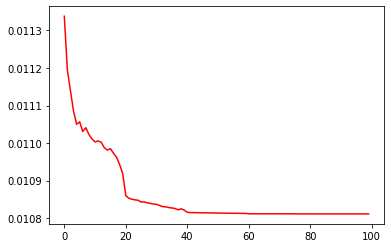

In [31]:
j = range(100)
plt.plot(j, train_loss_list, 'r')

### Verifying that AutoEncoder has not learnt the identity function

In [32]:
Net = AutoEncoder()
Net.load_state_dict(torch.load('../../saved_models/autoencoder7.pt'))
Net = Net.eval()
print(Net.encoder[0].weight)
print(Net.encoder[2].weight)
print(Net.decoder[0].weight)
print(Net.decoder[2].weight)

Parameter containing:
tensor([[[-0.1955,  0.2557, -0.1499, -0.1134, -0.1005],
         [ 0.0197,  0.0241, -0.1086,  0.1915,  0.0646],
         [-0.0764,  0.2619,  0.2046, -0.0671,  0.0863]],

        [[ 0.2935, -0.1531,  0.5589, -0.0183, -0.3799],
         [-0.0483, -0.2574, -0.2152, -0.0689,  0.2353],
         [ 0.3410, -0.0990,  0.4600, -0.2409,  0.6615]]], requires_grad=True)
Parameter containing:
tensor([[[-0.2323,  0.0605,  0.7728,  0.2239,  0.2218],
         [-0.4469,  0.3056, -0.0355, -0.3117,  0.3215]]], requires_grad=True)
Parameter containing:
tensor([[[ 0.2104, -0.5947, -0.6751, -0.1573, -0.4030],
         [ 0.8785,  0.2480,  0.1267, -0.0759, -0.2291]]], requires_grad=True)
Parameter containing:
tensor([[[ 0.2692, -0.0086, -0.2723,  0.2840,  0.4361],
         [-0.1442,  0.0909, -0.0595, -0.1661, -0.2702],
         [ 0.2332,  0.0544, -0.2774, -0.1472, -0.5723]],

        [[-0.3330, -0.0739, -0.0457,  0.1459,  0.0811],
         [ 0.2018,  0.1886, -0.0102, -0.1311, -0.1709],
  

### Checking reconstruction quality visually
Works correctly now!

0.012046675197780132


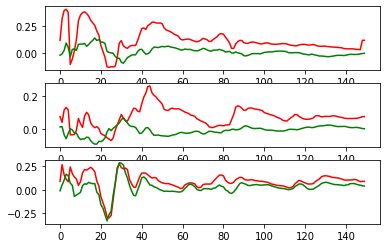

In [36]:
x = next(iter(testloader2))
y = Net.forward(x.float())
loss = criterion(torch.transpose(x, 1, 2).float(), y)

x = torch.transpose(x, 1, 2)
x = x.detach().numpy()
y = y.detach().numpy()

fig, ax = plt.subplots(3, 1)
ax[0].plot(x[0][0], 'r')
ax[0].plot(y[0][0], 'g')
print(loss.item())
ax[1].plot(x[0][1], 'r')
ax[1].plot(y[0][1], 'g')
ax[2].plot(x[0][2], 'r')
ax[2].plot(y[0][2], 'g')

### Now training the classifier

In [38]:
reqd_len = 150
channels = 3
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' :
            self.df = pd.read_csv('../../data/train.csv', header = None)
        elif mode == 'test' :
            self.df = pd.read_csv('../../data/test.csv', header = None)
        elif mode == 'val' :
            self.df = pd.read_csv('../../data/val.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        y = self.df.iloc[idx : idx + reqd_len, 3 : ].values
        ind = np.argmax(np.sum(y, axis = 0))
        label = np.zeros_like(self.df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        x = x.reshape(reqd_len, channels)
        assert(x.shape == (reqd_len, channels))
        assert(label.shape == (5, ))
        return x, label
        
trainset = IMUDataset(mode = 'train')
valset = IMUDataset(mode = 'val')
testset = IMUDataset(mode = 'test')

(128100, 8)
(15900, 8)
(16200, 8)


In [39]:
train_batch_size = 8
batch_size = 8
train_indices = [(i * reqd_len) for i in range(len(trainset) // reqd_len)]
val_indices = [(i * reqd_len) for i in range(len(valset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(testset) // reqd_len)]

trainloader = DataLoader(trainset, batch_size = train_batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
valloader = DataLoader(valset, batch_size = batch_size, sampler = SubsetRandomSampler(val_indices), drop_last = True)
testloader = DataLoader(testset, batch_size = batch_size, sampler = SubsetRandomSampler(test_indices), drop_last = True)

In [45]:
# Loading autoencoder saved model
Net = AutoEncoder()
Net.load_state_dict(torch.load('../../saved_models/autoencoder7.pt'), strict = False)
# # freezing encoder and decoder layers
Net.encoder[0].requires_grad = False
Net.encoder[2].requires_grad = False
Net.decoder[0].requires_grad = False
Net.decoder[2].requires_grad = False
Net = Net.cuda()

In [46]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3)

In [47]:
num_epochs = 30
total_step = len(trainset) // (train_batch_size * 150)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net.forward(images, classify = True)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net.forward(images, classify = True)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), 'autoencoder_classifier2.pt')

epoch =  0  step =  0  of total steps  106  loss =  1.6616981029510498
epoch =  0  step =  20  of total steps  106  loss =  1.4755046367645264
epoch =  0  step =  40  of total steps  106  loss =  1.583512783050537
epoch =  0  step =  60  of total steps  106  loss =  1.6643037796020508
epoch =  0  step =  80  of total steps  106  loss =  1.5982753038406372
epoch =  0  step =  100  of total steps  106  loss =  1.3043434619903564
epoch :  0  /  30  | TL :  1.521053190501231  | VL :  1.536023736000061
saving model
epoch =  1  step =  0  of total steps  106  loss =  1.5141394138336182
epoch =  1  step =  20  of total steps  106  loss =  1.1409122943878174
epoch =  1  step =  40  of total steps  106  loss =  1.327758550643921
epoch =  1  step =  60  of total steps  106  loss =  1.3205080032348633
epoch =  1  step =  80  of total steps  106  loss =  1.2297136783599854
epoch =  1  step =  100  of total steps  106  loss =  1.4829418659210205
epoch :  1  /  30  | TL :  1.452169250767186  | VL : 

epoch =  16  step =  20  of total steps  106  loss =  0.34795552492141724
epoch =  16  step =  40  of total steps  106  loss =  0.28137606382369995
epoch =  16  step =  60  of total steps  106  loss =  0.8828293681144714
epoch =  16  step =  80  of total steps  106  loss =  0.36869165301322937
epoch =  16  step =  100  of total steps  106  loss =  0.47347307205200195
epoch :  16  /  30  | TL :  0.4463634747519808  | VL :  2.516789436340332
epoch =  17  step =  0  of total steps  106  loss =  0.33694392442703247
epoch =  17  step =  20  of total steps  106  loss =  0.42580318450927734
epoch =  17  step =  40  of total steps  106  loss =  0.48576775193214417
epoch =  17  step =  60  of total steps  106  loss =  0.3165721297264099
epoch =  17  step =  80  of total steps  106  loss =  0.21983814239501953
epoch =  17  step =  100  of total steps  106  loss =  0.5477741956710815
epoch :  17  /  30  | TL :  0.4206211820051496  | VL :  2.4691269397735596
epoch =  18  step =  0  of total steps 

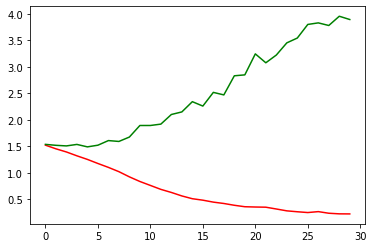

In [48]:
j = np.arange(30)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [49]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float()
        labels = Variable(labels).float()

        outputs = Net(images, classify = True)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net = Net.cpu().eval()
# _get_accuracy(trainloader)

In [50]:
print(_get_accuracy(trainloader, Net))
print(_get_accuracy(testloader, Net))
print(_get_accuracy(valloader, Net))

0.9540094339622641
0.2980769230769231
0.375


The symmetrical fully convolutional autoencoder doesn't work well. So, next we try using an asymmetrical autoencoder (asymmetrical since it will only have maxpool in encoder) (TODO)

In [32]:
# TODO - (MEDIUM-PRIORITY)
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # defining layers
        self.conv1 = nn.Conv1d(3, 10, 3)
        self.mp = nn.MaxPool1d(2, 2)
        
        self.dconv1 = nn.ConvTranspose1d(10, 3, 3)
        nn.init.xavier_uniform_(self.conv1.weight, gain = nn.init.calculate_gain('relu'))
        
    def forward(self, signal):
        signal = signal.view(-1, 150 * 3)
        out = F.relu(self.fc1(signal))
        out = F.relu(self.fc2(out))
        out = F.log_softmax(self.fc3(out), dim = 1)
        return out

Net = AutoEncoder()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()